In [1]:
from sklearn.preprocessing import StandardScaler
import pyupbit
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import shap
from scipy.special import softmax

In [2]:
# 데이터 로드
ticker = 'KRW-BTC'
interval = 'minute3'
to = '2024-10-31 09:00'
count = 13440
data = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=count)
# 이동평균 3과 5 추가
data['ma_3'] = data['close'].rolling(window=3).mean()  # 3-period 이동평균
data['ma_5'] = data['close'].rolling(window=5).mean()  # 5-period 이동평균
# 중간가 추가
data['middle'] = (data['high'] + data['low']) / 2

#1달 데이터 3분간격

In [3]:
# NaN 값 제거 (초기 구간에서는 이동평균 계산 불가)
data = data.dropna()

In [4]:
data['timestamp'] = data.index  # 인덱스를 열로 변환
data['minute'] = data['timestamp'].dt.minute
data['hour'] = data['timestamp'].dt.hour
data['day'] = data['timestamp'].dt.day


In [5]:
data

,open,high,low,close,volume,value,ma_3,ma_5,middle,timestamp,minute,hour,day
2024-10-03 12:39:00,82505000.0,82505000.0,82427000.0,82505000.0,2.966659,2.447083e+08,8.253700e+07,82558400.0,82466000.0,2024-10-03 12:39:00,39,12,3
2024-10-03 12:42:00,82500000.0,82505000.0,82423000.0,82499000.0,1.690431,1.393662e+08,8.249833e+07,82546000.0,82464000.0,2024-10-03 12:42:00,42,12,3
2024-10-03 12:45:00,82499000.0,82593000.0,82433000.0,82482000.0,3.699225,3.052489e+08,8.249533e+07,82518400.0,82513000.0,2024-10-03 12:45:00,45,12,3
2024-10-03 12:48:00,82590000.0,82591000.0,82500000.0,82589000.0,0.558138,4.609081e+07,8.252333e+07,82513200.0,82545500.0,2024-10-03 12:48:00,48,12,3
2024-10-03 12:51:00,82590000.0,82610000.0,82540000.0,82609000.0,2.760618,2.280237e+08,8.256000e+07,82536800.0,82575000.0,2024-10-03 12:51:00,51,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 17:45:00,100419000.0,100445000.0,100402000.0,100416000.0,1.881093,1.888933e+08,1.004213e+08,100428200.0,100423500.0,2024-10-31 17:45:00,45,17,31
2024-10-31 17:48:00,100416000.0,100454000.0,100401000.0,100416000.0,2.048091,2.056766e+08,1.004170e+08,100426000.0,100427500.0,2024-10-31 17:48:00,48,17,31
2024-10-31 17:51:00,100416000.0,100479000.0,100401000.0,100451000.0,2.179007,2.188510e+08,1.004277e+08,100426200.0,100440000.0,2024-10-31 17:51:00,51,17,31
2024-10-31 17:54:00,100451000.0,100541000.0,100451000.0,100541000.0,2.542313,2.554695e+08,1.004693e+08,100448600.0,100496000.0,2024-10-31 17:54:00,54,17,31


In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['open', 'high', 'low', 'close', 'volume','ma_3','ma_5', 'middle']])


In [13]:
scaled_data

array([[0.08582788, 0.07636996, 0.0838755 , ..., 0.0834615 , 0.08327496,
        0.08004409],
       [0.08559401, 0.07636996, 0.08368828, ..., 0.08164098, 0.08268805,
        0.07995028],
       [0.08554724, 0.08050569, 0.08415633, ..., 0.08149973, 0.0813817 ,
        0.08224865],
       ...,
       [0.92357343, 0.92109221, 0.92515797, ..., 0.92579805, 0.92898389,
        0.92312202],
       [0.92521048, 0.92400602, 0.92749824, ..., 0.92775982, 0.93004411,
        0.92574873],
       [0.92937325, 0.92536893, 0.93166394, ..., 0.93000408, 0.93136939,
        0.92851615]])

In [40]:
import numpy as np

def create_sequences(data, seq_length=60):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length][-1])  # 'close'를 예측 값으로 사용
    return np.array(sequences), np.array(targets)

seq_length = 60  # 과거 60개의 데이터로 다음 값을 예측
X, y = create_sequences(scaled_data, seq_length)


In [41]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Attention Layer 정의
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden_states):
        # hidden_states: [batch_size, seq_len, hidden_dim]
        scores = self.attention(hidden_states)  # [batch_size, seq_len, 1]
        weights = torch.softmax(scores, dim=1)  # Normalize over sequence length
        context = torch.sum(weights * hidden_states, dim=1)  # Weighted sum
        return context, weights

# LSTM + Attention 모델 정의
class LSTMAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # LSTM output: [batch_size, seq_len, hidden_dim]
        context, weights = self.attention(lstm_out)  # Attention: context + weights
        output = self.fc(context)  # Final prediction
        return output, weights


In [42]:
# 입력 데이터와 타겟 데이터 준비
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [43]:
# 모델 초기화
input_dim = 8  # 입력 특성 개수 (open, high, low, close, volume, middle)
hidden_dim = 64  # LSTM의 은닉층 크기
output_dim = 1  # 예측 값의 크기
num_layers = 2  # LSTM 레이어 수

model = LSTMAttentionModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
epochs = 20
for epoch in range(epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        output, _ = model(batch_X)  # 모델 출력과 Attention 가중치
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/20, Loss: 0.0003
Epoch 2/20, Loss: 0.0001
Epoch 3/20, Loss: 0.0002
Epoch 4/20, Loss: 0.0002
Epoch 5/20, Loss: 0.0003
Epoch 6/20, Loss: 0.0002
Epoch 7/20, Loss: 0.0002
Epoch 8/20, Loss: 0.0002
Epoch 9/20, Loss: 0.0002
Epoch 10/20, Loss: 0.0004
Epoch 11/20, Loss: 0.0003
Epoch 12/20, Loss: 0.0004
Epoch 13/20, Loss: 0.0003
Epoch 14/20, Loss: 0.0001
Epoch 15/20, Loss: 0.0003
Epoch 16/20, Loss: 0.0001
Epoch 17/20, Loss: 0.0002
Epoch 18/20, Loss: 0.0001
Epoch 19/20, Loss: 0.0003
Epoch 20/20, Loss: 0.0003


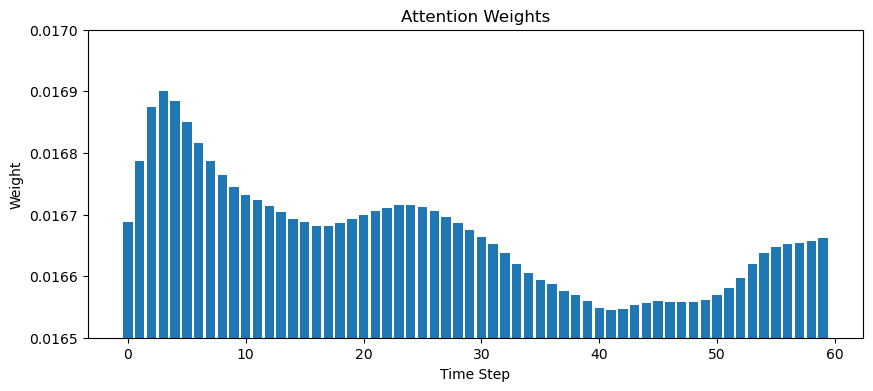

In [44]:
# Attention 가중치 계산
model.eval()
sample_input = X_tensor[0:1]  # 샘플 데이터 (배치 크기 1)
_, attention_weights = model(sample_input)

# Attention 가중치 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.bar(range(attention_weights.size(1)), attention_weights[0].detach().numpy().flatten())
plt.title("Attention Weights")
plt.xlabel("Time Step")
plt.ylabel("Weight")
plt.ylim(0.0165, 0.017)
plt.show()


In [45]:
# 특성 중요도와 평균 가중치 계산

In [46]:
class FeatureAttention(nn.Module):
    def __init__(self, seq_len, hidden_dim):
        super(FeatureAttention, self).__init__()
        self.attention = nn.Linear(seq_len, 1, bias=False)  # Feature-wise Attention

    def forward(self, x):
        # x: [batch_size, seq_len, hidden_dim]
        x_transposed = x.transpose(1, 2)  # [batch_size, hidden_dim, seq_len]
        scores = self.attention(x_transposed)  # [batch_size, hidden_dim, 1]
        weights = torch.softmax(scores, dim=1)  # Normalize across hidden_dim
        context = torch.sum(weights * x_transposed, dim=2)  # [batch_size, hidden_dim]
        return context, weights


In [47]:
class LSTMFeatureAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMFeatureAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.feature_attention = FeatureAttention(seq_len=60, hidden_dim=hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)  # FC Layer for final output

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # LSTM output: [batch_size, seq_len, hidden_dim]
        feature_context, feature_weights = self.feature_attention(lstm_out)
        output = self.fc(feature_context)  # Final prediction
        return output, feature_weights


In [48]:
# 모델 초기화
model = LSTMFeatureAttentionModel(input_dim=8, hidden_dim=64, output_dim=1, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습 루프
epochs = 20
for epoch in range(epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        output, _ = model(batch_X)
        loss = criterion(output.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/20, Loss: 0.0003
Epoch 2/20, Loss: 0.0002
Epoch 3/20, Loss: 0.0002
Epoch 4/20, Loss: 0.0002
Epoch 5/20, Loss: 0.0001
Epoch 6/20, Loss: 0.0002
Epoch 7/20, Loss: 0.0003
Epoch 8/20, Loss: 0.0002
Epoch 9/20, Loss: 0.0002
Epoch 10/20, Loss: 0.0001
Epoch 11/20, Loss: 0.0001
Epoch 12/20, Loss: 0.0002
Epoch 13/20, Loss: 0.0003
Epoch 14/20, Loss: 0.0002
Epoch 15/20, Loss: 0.0002
Epoch 16/20, Loss: 0.0001
Epoch 17/20, Loss: 0.0001
Epoch 18/20, Loss: 0.0002
Epoch 19/20, Loss: 0.0002
Epoch 20/20, Loss: 0.0001


In [49]:
# 모델 평가 모드
model.eval()

# 샘플 데이터 선택 (batch_size=1)
sample_input = X_tensor[:1]  # [1, seq_len, num_features]

# 모델 통과
with torch.no_grad():
    _, feature_weights = model(sample_input)  # Feature-wise attention weights

# Attention 가중치 크기 확인
print(f"Feature Attention Weights Shape: {feature_weights.shape}")


Feature Attention Weights Shape: torch.Size([1, 64, 1])


In [50]:
avg_feature_weights_per_feature

array([0.01612088, 0.01469529, 0.01458275, 0.01503595, 0.01708726,
       0.01503715, 0.01653016, 0.01455001], dtype=float32)

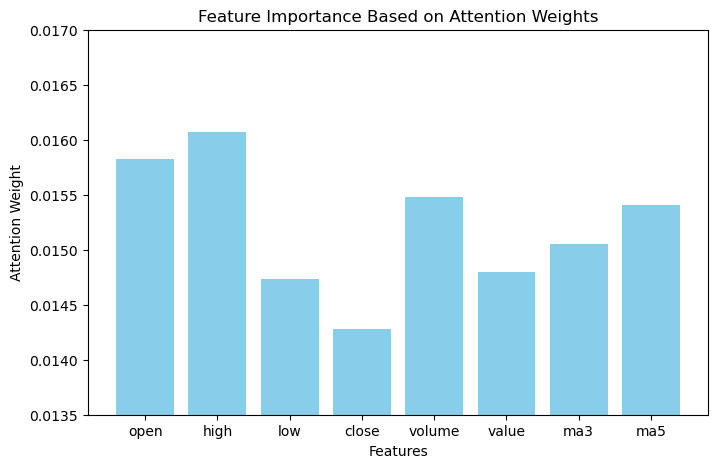

In [52]:
# Feature Attention 가중치 (특성별로 평균 계산)
avg_feature_weights = feature_weights.mean(dim=0).squeeze().numpy()  # [hidden_dim]
avg_feature_weights_per_feature = avg_feature_weights[:8]  # 특성 8개에 맞게 잘라내기

# Feature 이름
features = ['open', 'high', 'low', 'close', 'volume', 'value','ma3','ma5']

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(features, avg_feature_weights_per_feature, color='skyblue')
plt.title('Feature Importance Based on Attention Weights')
plt.xlabel('Features')
plt.ylabel('Attention Weight')
# Y축 범위 조정
plt.ylim(0.0135, 0.017)

plt.show()


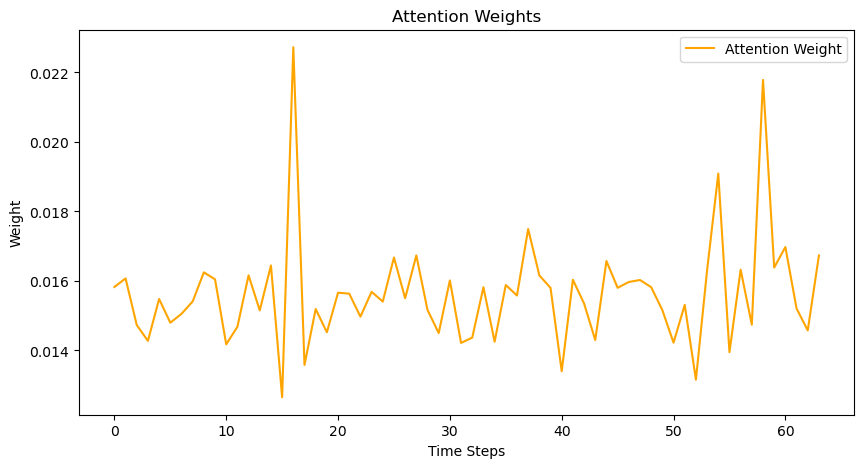

In [53]:
# Attention 가중치 추출
with torch.no_grad():
    _, feature_weights = model(sample_input)  # Feature-wise attention weights

# 시간별 평균 Attention 중요도 계산
time_step_weights = feature_weights.mean(axis=2).squeeze().numpy()  # [seq_len]

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(time_step_weights, label='Attention Weight', color='orange')
plt.title('Attention Weights')
plt.xlabel('Time Steps')
plt.ylabel('Weight')
plt.legend()
plt.show()


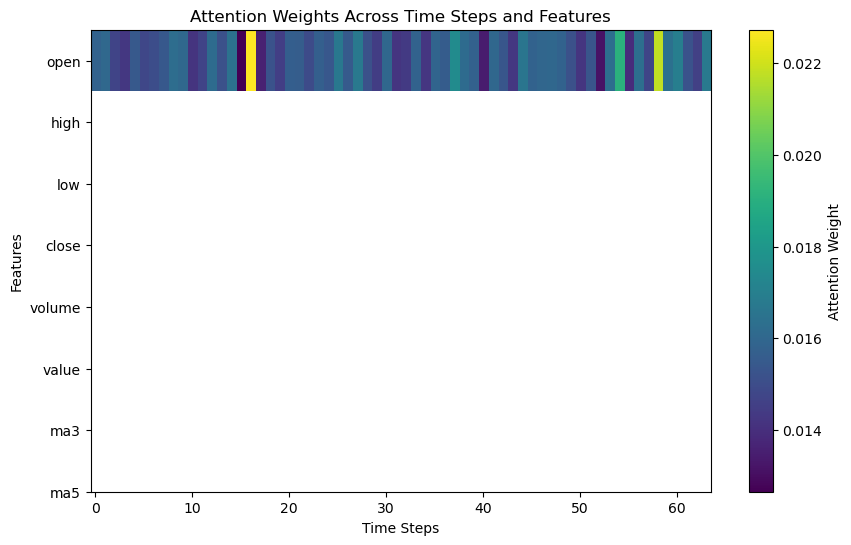

In [54]:
# Attention 가중치 추출
model.eval()
with torch.no_grad():
    _, feature_weights = model(sample_input)

# Feature Attention 가중치를 (time_steps, features)로 변환
feature_weights_2d = feature_weights.squeeze().numpy()
if feature_weights_2d.ndim == 1:
    feature_weights_2d = feature_weights_2d.reshape(-1, 1)

# 시각화
plt.figure(figsize=(10, 6))
plt.imshow(feature_weights_2d.T, cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.title('Attention Weights Across Time Steps and Features')
plt.xlabel('Time Steps')
plt.ylabel('Features')
plt.yticks(ticks=np.arange(len(features)), labels=features)
plt.show()
